# Recursive least squares

Recursive least squares is an expanding window version of ordinary least squares. In addition to availability of regression coefficients computed recursively, the recursively computed residuals the construction of statistics to investigate parameter instability.

The `RecursiveLS` class allows computation of recursive residuals and computes CUSUM and CUSUM of squares statistics. Plotting these statistics along with reference lines denoting statistically significant deviations from the null hypothesis of stable parameters allows an easy visual indication of parameter stability.

Finally, the `RecursiveLS` model allows imposing linear restrictions on the parameter vectors, and can be constructed using the formula interface.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas_datareader.data import DataReader

np.set_printoptions(suppress=True)

## Example 1: Copper

We first consider parameter stability in the copper dataset (description below).

In [2]:
print(sm.datasets.copper.DESCRLONG)

dta = sm.datasets.copper.load_pandas().data
dta.index = pd.date_range("1951-01-01", "1975-01-01", freq="AS")
endog = dta["WORLDCONSUMPTION"]

# To the regressors in the dataset, we add a column of ones for an intercept
exog = sm.add_constant(
    dta[["COPPERPRICE", "INCOMEINDEX", "ALUMPRICE", "INVENTORYINDEX"]]
)

This data describes the world copper market from 1951 through 1975.  In an
example, in Gill, the outcome variable (of a 2 stage estimation) is the world
consumption of copper for the 25 years.  The explanatory variables are the
world consumption of copper in 1000 metric tons, the constant dollar adjusted
price of copper, the price of a substitute, aluminum, an index of real per
capita income base 1970, an annual measure of manufacturer inventory change,
and a time trend.



First, construct and fit the model, and print a summary. Although the `RLS` model computes the regression parameters recursively, so there are as many estimates as there are datapoints, the summary table only presents the regression parameters estimated on the entire sample; except for small effects from initialization of the recursions, these estimates are equivalent to OLS estimates.

In [3]:
mod = sm.RecursiveLS(endog, exog)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:       WORLDCONSUMPTION   No. Observations:                   25
Model:                    RecursiveLS   Log Likelihood                -154.720
Date:                Wed, 02 Nov 2022   R-squared:                       0.965
Time:                        17:06:36   AIC                            319.441
Sample:                    01-01-1951   BIC                            325.535
                         - 01-01-1975   HQIC                           321.131
Covariance Type:            nonrobust   Scale                       117717.127
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6562.3719   2378.939     -2.759      0.006   -1.12e+04   -1899.737
COPPERPRICE      -13.8132     15.041     -0.918      0.358     -43.292      15.666
INCOMEINDEX      1.21e+04    763.401

The recursive coefficients are available in the `recursive_coefficients` attribute. Alternatively, plots can generated using the `plot_recursive_coefficient` method.

[     2.88890087      4.94795049   1558.41803044   1958.43326657
 -51474.95389825  -4168.95149564  -2252.61355052   -446.5591456
  -5288.39795594  -6942.31935565  -7846.08902726  -6643.15121671
  -6274.1101596   -7272.01696687  -6319.02648931  -5822.23929496
  -6256.30903085  -6737.40446361  -6477.42841937  -5995.9074752
  -6450.80678458  -6022.92167008  -5258.35153117  -5320.89136734
  -6562.37193956]


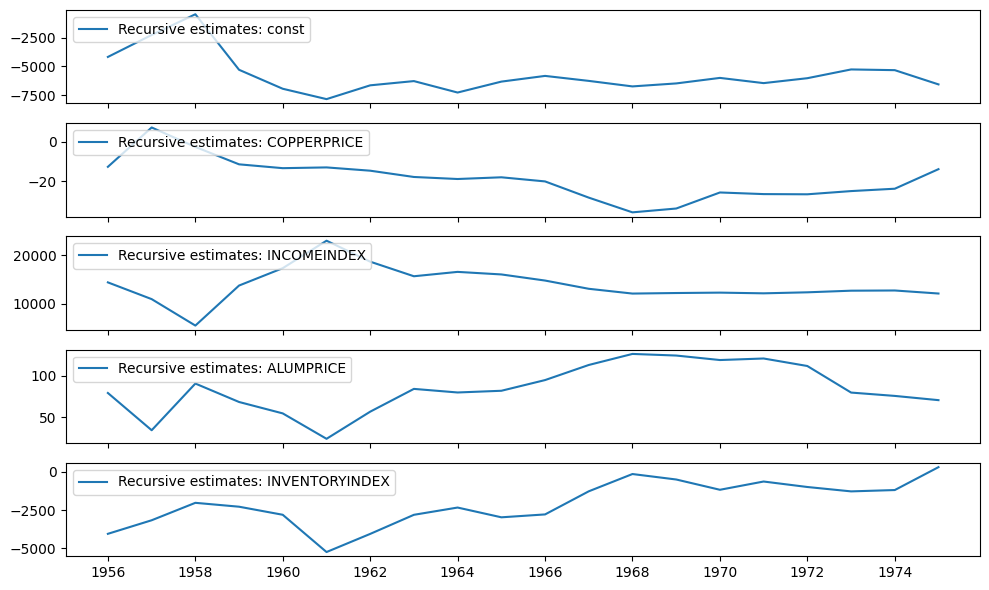

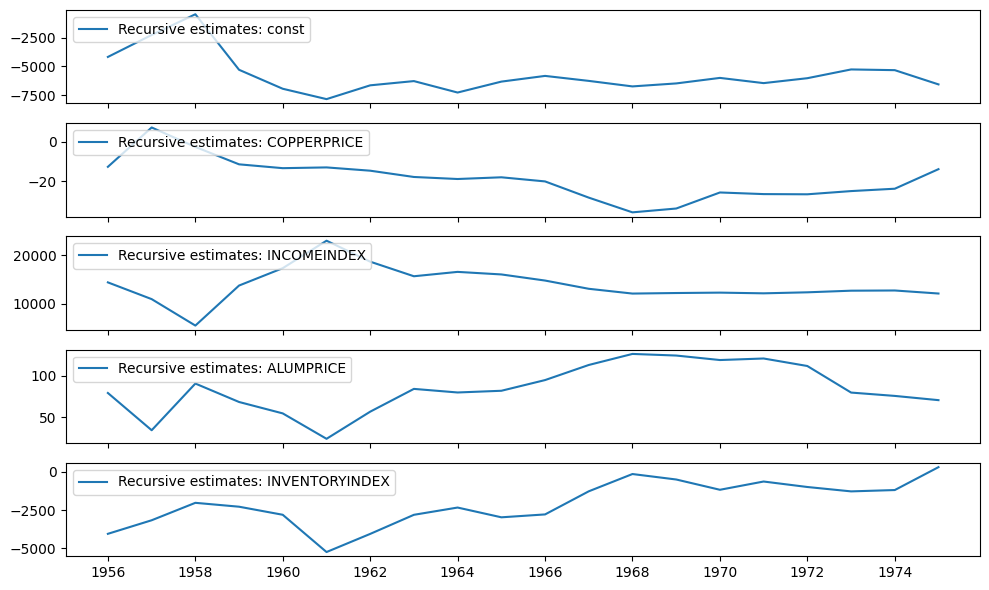

In [4]:
print(res.recursive_coefficients.filtered[0])
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10, 6))

The CUSUM statistic is available in the `cusum` attribute, but usually it is more convenient to visually check for parameter stability using the `plot_cusum` method. In the plot below, the CUSUM statistic does not move outside of the 5% significance bands, so we fail to reject the null hypothesis of stable parameters at the 5% level.

[ 0.69971507  0.65841239  1.2462967   2.05476027  2.39888914  3.17861975
  2.67244668  2.01783211  2.46131743  2.05268634  0.95054332 -1.04505551
 -2.5546529  -2.29908156 -1.45289497 -1.95353998 -1.35046625  0.15789824
  0.63286526 -1.4818459 ]


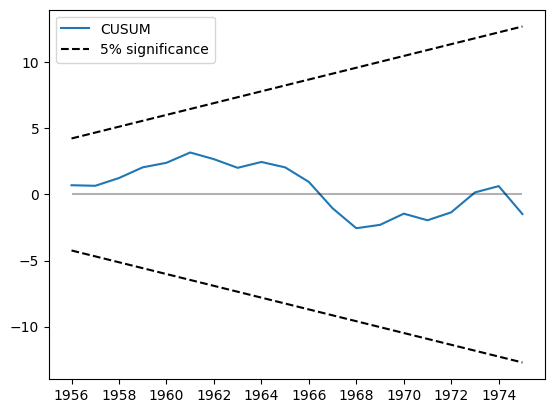

In [5]:
print(res.cusum)
fig = res.plot_cusum()

Another related statistic is the CUSUM of squares. It is available in the `cusum_squares` attribute, but it is similarly more convenient to check it visually, using the `plot_cusum_squares` method. In the plot below, the CUSUM of squares statistic does not move outside of the 5% significance bands, so we fail to reject the null hypothesis of stable parameters at the 5% level.

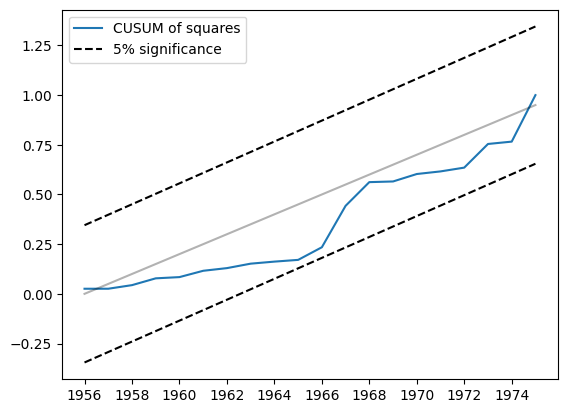

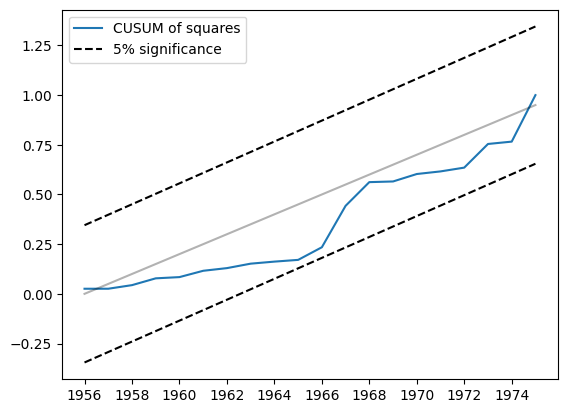

In [6]:
res.plot_cusum_squares()

## Example 2: Quantity theory of money

The quantity theory of money suggests that "a given change in the rate of change in the quantity of money induces ... an equal change in the rate of price inflation" (Lucas, 1980). Following Lucas, we examine the relationship between double-sided exponentially weighted moving averages of money growth and CPI inflation. Although Lucas found the relationship between these variables to be stable, more recently it appears that the relationship is unstable; see e.g. Sargent and Surico (2010).

In [7]:
start = "1959-12-01"
end = "2015-01-01"
m2 = DataReader("M2SL", "fred", start=start, end=end)
cpi = DataReader("CPIAUCSL", "fred", start=start, end=end)

In [8]:
def ewma(series, beta, n_window):
    nobs = len(series)
    scalar = (1 - beta) / (1 + beta)
    ma = []
    k = np.arange(n_window, 0, -1)
    weights = np.r_[beta ** k, 1, beta ** k[::-1]]
    for t in range(n_window, nobs - n_window):
        window = series.iloc[t - n_window : t + n_window + 1].values
        ma.append(scalar * np.sum(weights * window))
    return pd.Series(ma, name=series.name, index=series.iloc[n_window:-n_window].index)


m2_ewma = ewma(np.log(m2["M2SL"].resample("QS").mean()).diff().iloc[1:], 0.95, 10 * 4)
cpi_ewma = ewma(
    np.log(cpi["CPIAUCSL"].resample("QS").mean()).diff().iloc[1:], 0.95, 10 * 4
)

After constructing the moving averages using the $\beta = 0.95$ filter of Lucas (with a window of 10 years on either side), we plot each of the series below. Although they appear to move together prior for part of the sample, after 1990 they appear to diverge.

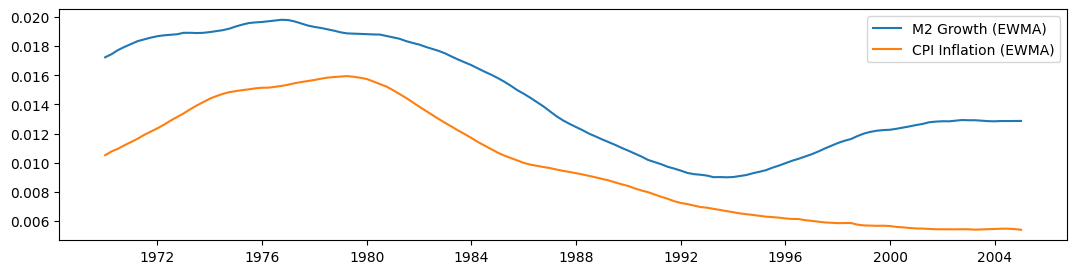

In [9]:
fig, ax = plt.subplots(figsize=(13, 3))

ax.plot(m2_ewma, label="M2 Growth (EWMA)")
ax.plot(cpi_ewma, label="CPI Inflation (EWMA)")
ax.legend()

In [10]:
endog = cpi_ewma
exog = sm.add_constant(m2_ewma)
exog.columns = ["const", "M2"]

mod = sm.RecursiveLS(endog, exog)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:               CPIAUCSL   No. Observations:                  141
Model:                    RecursiveLS   Log Likelihood                 692.884
Date:                Wed, 02 Nov 2022   R-squared:                       0.813
Time:                        17:06:38   AIC                          -1381.769
Sample:                    01-01-1970   BIC                          -1375.871
                         - 01-01-2005   HQIC                         -1379.372
Covariance Type:            nonrobust   Scale                            0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.001     -6.014      0.000      -0.004      -0.002
M2             0.9128      0.037     24.603      0.000       0.840       0.986
Ljung-Box (L1) (Q):                 138.24   Jarque-

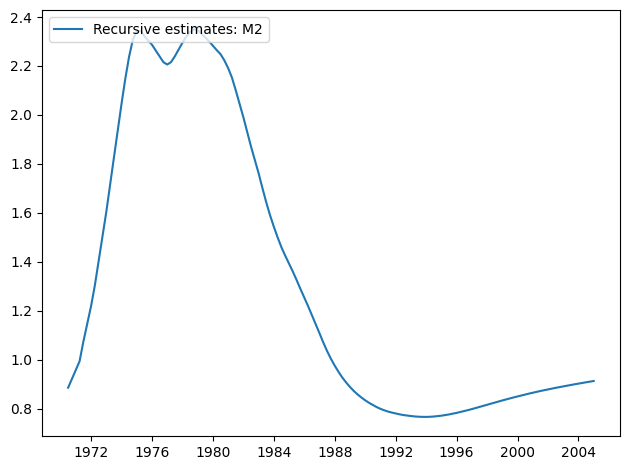

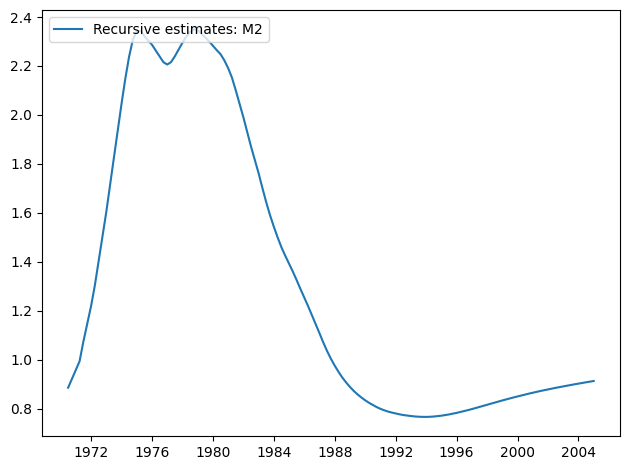

In [11]:
res.plot_recursive_coefficient(1, alpha=None)

The CUSUM plot now shows substantial deviation at the 5% level, suggesting a rejection of the null hypothesis of parameter stability.

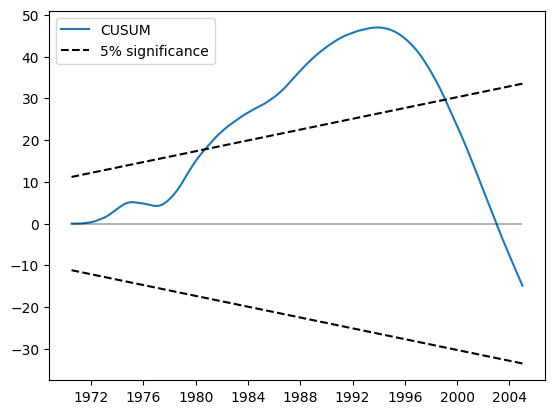

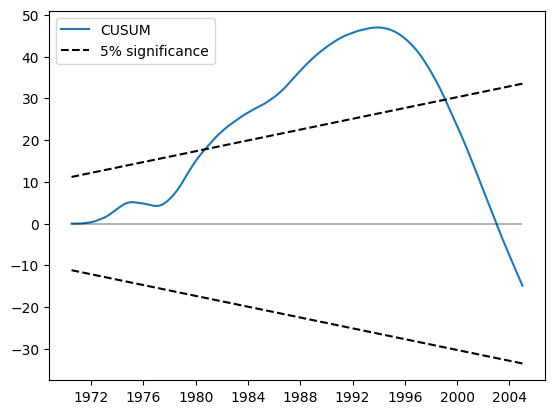

In [12]:
res.plot_cusum()

Similarly, the CUSUM of squares shows substantial deviation at the 5% level, also suggesting a rejection of the null hypothesis of parameter stability.

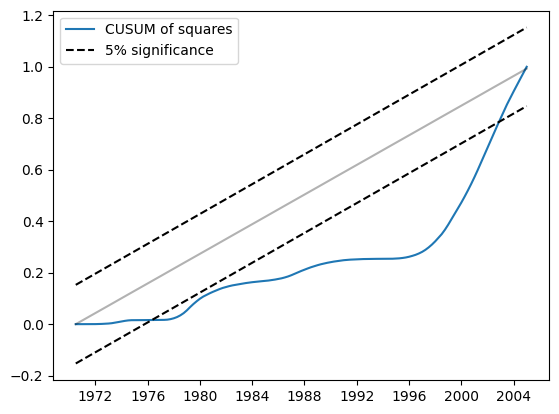

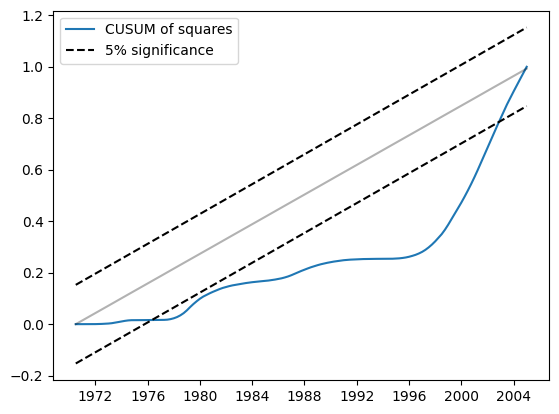

In [13]:
res.plot_cusum_squares()

## Example 3: Linear restrictions and formulas

## Linear restrictions

It is not hard to implement linear restrictions, using the `constraints` parameter in constructing the model.

In [14]:
endog = dta["WORLDCONSUMPTION"]
exog = sm.add_constant(
    dta[["COPPERPRICE", "INCOMEINDEX", "ALUMPRICE", "INVENTORYINDEX"]]
)

mod = sm.RecursiveLS(endog, exog, constraints="COPPERPRICE = ALUMPRICE")
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:       WORLDCONSUMPTION   No. Observations:                   25
Model:                    RecursiveLS   Log Likelihood                -144.004
Date:                Wed, 02 Nov 2022   R-squared:                       0.989
Time:                        17:06:39   AIC                            296.008
Sample:                    01-01-1951   BIC                            300.883
                         - 01-01-1975   HQIC                           297.360
Covariance Type:            nonrobust   Scale                       137155.014
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4839.4893   2412.410     -2.006      0.045   -9567.726    -111.253
COPPERPRICE        5.9797     12.704      0.471      0.638     -18.921      30.880
INCOMEINDEX     1.115e+04    666.308

## Formula

One could fit the same model using the class method `from_formula`.

In [15]:
mod = sm.RecursiveLS.from_formula(
    "WORLDCONSUMPTION ~ COPPERPRICE + INCOMEINDEX + ALUMPRICE + INVENTORYINDEX",
    dta,
    constraints="COPPERPRICE = ALUMPRICE",
)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:       WORLDCONSUMPTION   No. Observations:                   25
Model:                    RecursiveLS   Log Likelihood                -144.004
Date:                Wed, 02 Nov 2022   R-squared:                       0.989
Time:                        17:06:39   AIC                            296.008
Sample:                    01-01-1951   BIC                            300.883
                         - 01-01-1975   HQIC                           297.360
Covariance Type:            nonrobust   Scale                       137155.014
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -4839.4893   2412.410     -2.006      0.045   -9567.726    -111.253
COPPERPRICE        5.9797     12.704      0.471      0.638     -18.921      30.880
INCOMEINDEX     1.115e+04    666.308

/opt/hostedtoolcache/Python/3.10.8/x64/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
